**Problem statement**

Your objective is to develop the Behaviour Score for Bank A.

Credit Cards that have actually defaulted have bad_flag = 1.

* Onus attributes like credit limit (variables with names starting with onus_attributes)

* Transaction level attributes like number of transactions / rupee value transactions on various kinds of merchants (variables with names starting with transaction_attribute)

* Bureau tradeline level attributes (like product holdings, historical delinquencies) – variables starting with bureau

* Bureau enquiry level attributes (like PL enquiries in the last 3 months etc) – variables starting with bureau_enquiry



In [ ]:
#Importing necessary libraries to be used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

In [ ]:
!pip install pycaret

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Conclave 3.0/Dev_data_to_be_shared.csv")
data.shape

(96806, 1216)

In [ ]:
data['bad_flag'].value_counts()

,count
bad_flag,
0,95434
1,1372


*Out of 96,806 accounts, 1372 accounts have a bad_flag*

###**Checking if there are any columns with Object Datatype**

In [ ]:
object_col = data.select_dtypes(include = ['object'])

if not object_col.empty:
    print("Object columns found:")
    print(object_col.columns)
else:
    print("No object columns found.")

No object columns found.


###**Managing NULL values**

In [ ]:
data = data.dropna(axis = 1, how = 'all')
num_features = data.select_dtypes(include=[np.number]).columns
num_imputer = SimpleImputer(strategy = 'mean')
data[num_features] = num_imputer.fit_transform(data[num_features])
data.shape
#Two columns were removed as they had completely Null space

(96806, 1214)

In [ ]:
data.isnull().sum().sum() #Showing that now there are no NULL values present in the dataframe.

0

###**Aggregating**

In [ ]:
transaction_attributes = [col for col in data.columns if col.startswith('transaction_attribute')]
bureau_attributes = [col for col in data.columns if col.startswith('bureau')]
onus_attributes = [col for col in data.columns if col.startswith('onus_attribute')]

In [ ]:
#Transaction Attributes
data['transaction_attribute_sum'] = data[transaction_attributes].sum(axis = 1)
data['transaction_attribute_mean'] = data[transaction_attributes].mean(axis = 1)
data['transaction_attribute_std'] = data[transaction_attributes].std(axis = 1)
data['transaction_attribute_min'] = data[transaction_attributes].min(axis = 1)
data['transaction_attribute_max'] = data[transaction_attributes].max(axis = 1)

#Bureau Attributes
data['bureau_sum'] = data[bureau_attributes].sum(axis = 1)
data['bureau_mean'] = data[bureau_attributes].mean(axis = 1)
data['bureau_std'] = data[bureau_attributes].std(axis = 1)
data['bureau_min'] = data[bureau_attributes].min(axis = 1)
data['bureau_max'] = data[bureau_attributes].max(axis = 1)
data['recent_enquiries'] = data['bureau_enquiry_12'] + data['bureau_enquiry_13'] + data['bureau_enquiry_14']

#Ratios
data['transaction_attribute_ratio'] = data['transaction_attribute_sum'] / data['bureau_sum']
data['bureau_ratio'] = data['bureau_sum'] / data['transaction_attribute_sum']
data['spend_vs_enquiry'] = data['transaction_attribute_sum'] / (data['bureau_sum'] + 1e-6)
data['enquiry_vs_spend'] = data['bureau_sum'] / (data['transaction_attribute_sum'] + 1e-6)

if 'onus_attribute_1' in data.columns:
  data['transaction_limit_ratio'] = data['transaction_attribute_sum']/(data['onus_attribute_1'] + 1e-6)
  data['inquiries_limit_ratio'] = data['bureau_sum']/(data['onus_attribute_1'] + 1e-6)

#Flags
data['high_credit_utilization'] = (data['transaction_limit_ratio'] > 0.7).astype(int)
data['credit_overutilization'] = (data['transaction_limit_ratio'] > 0.9).astype(int)
data['low_credit_utilization'] = (data['transaction_limit_ratio'] < 0.3).astype(int)
data['high_inquiries'] = (data['inquiries_limit_ratio'] > 0.7).astype(int)
data['low_inquiries'] = (data['inquiries_limit_ratio'] < 0.3).astype(int)


data.shape

<ipython-input-54-0166e329f581>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['transaction_attribute_sum'] = data[transaction_attributes].sum(axis = 1)
<ipython-input-54-0166e329f581>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['transaction_attribute_mean'] = data[transaction_attributes].mean(axis = 1)
<ipython-input-54-0166e329f581>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

(96806, 1236)

###**Exploratory Data Analysis**

In [ ]:
#pivot table between bad_flag and counting credit_overutilization for each class
data_pivot = data.pivot_table(index='bad_flag', columns='credit_overutilization', values='account_number', aggfunc='count')
print(data_pivot)

credit_overutilization    0        1
bad_flag                            
0.0                     9.0  95425.0
1.0                     NaN   1372.0


###**Feature Engineering**

In [ ]:
X = data.drop(columns=['bad_flag'], errors='ignore')
y = data['bad_flag']

In [ ]:
best_features = SelectKBest(score_func = mutual_info_classif, k=50)
X_new = best_features.fit_transform(X, y) #13mins 52 sec

This method basically utilizes mutual information. It calculates the mutual information value for each of the independent variables with respect to the dependent variable and selects the ones which have the most information gain. In other words, it basically measures the dependency of features with the target value. A higher score means more dependent variables.

In [ ]:
print(X_new.shape)
print(X_new.dtype)

(96806, 50)
float64


In [ ]:
selected_features = X.columns[best_features.get_support()]
print("Top 50 Selected Features:")
print(selected_features)

Top 50 Selected Features:
Index(['transaction_attribute_151', 'transaction_attribute_152',
       'transaction_attribute_190', 'transaction_attribute_191',
       'transaction_attribute_519', 'transaction_attribute_520',
       'transaction_attribute_524', 'transaction_attribute_525',
       'transaction_attribute_530', 'transaction_attribute_581',
       'transaction_attribute_582', 'transaction_attribute_620',
       'transaction_attribute_621', 'bureau_148', 'bureau_238', 'bureau_277',
       'bureau_278', 'bureau_315', 'bureau_317', 'bureau_318', 'bureau_355',
       'bureau_357', 'bureau_358', 'bureau_433', 'bureau_435', 'bureau_437',
       'bureau_438', 'bureau_444', 'bureau_448', 'bureau_449',
       'onus_attribute_2', 'onus_attribute_10', 'onus_attribute_13',
       'onus_attribute_16', 'onus_attribute_17', 'onus_attribute_19',
       'onus_attribute_20', 'onus_attribute_23', 'onus_attribute_25',
       'onus_attribute_26', 'onus_attribute_32', 'onus_attribute_43',
       'on

In [ ]:
#getting the feature names for X_new
#feature_names = best_features.get_feature_names_out(input_features=None)
X_new2 = pd.DataFrame(X_new, columns=selected_features)
X_new2.head()

,transaction_attribute_151,transaction_attribute_152,transaction_attribute_190,transaction_attribute_191,transaction_attribute_519,transaction_attribute_520,transaction_attribute_524,transaction_attribute_525,transaction_attribute_530,transaction_attribute_581,...,onus_attribute_32,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48,high_credit_utilization,credit_overutilization,high_inquiries
0,0.991867,1.0,0.993477,1.0,0.996677,0.997068,1.0,1.0,0.627545,0.989771,...,0.0,0.588114,1.497158,0.54565,1.430491,0.121447,0.119208,1.0,1.0,1.0
1,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,...,3.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0,1.0,1.0
2,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,...,0.0,0.588114,1.497158,0.54565,1.430491,0.121447,0.119208,1.0,1.0,1.0
3,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.333333,1.000000,...,0.0,0.588114,1.497158,0.54565,1.430491,0.121447,0.119208,1.0,1.0,1.0
4,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,...,0.0,0.588114,1.497158,0.54565,1.430491,0.121447,0.119208,1.0,1.0,1.0


###**Managing Class Imbalance**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new2, y, train_size = 0.6, random_state = 42, stratify = y)
#Apply ADASYN
adasyn = ADASYN(random_state = 42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
# Check the new class distribution
print("Before ADASYN:", y_train.value_counts())
print("")
print("After ADASYN:", y_train_adasyn.value_counts())
print("")
print("X_train original shape:", X_train.shape)
print("")
print("X_train_smote shape:", X_train_adasyn.shape)

Before ADASYN: bad_flag
0.0    57260
1.0      823
Name: count, dtype: int64

After ADASYN: bad_flag
1.0    57504
0.0    57260
Name: count, dtype: int64

X_train original shape: (58083, 50)

X_train_smote shape: (114764, 50)


###**Model Fitting**

In [ ]:
'''
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()
'''

'\nplt.figure()\nplt.plot(fpr, tpr, color=\'blue\', label=f"ROC Curve (AUC = {auc:.2f})")\nplt.plot([0, 1], [0, 1], color=\'red\', linestyle=\'--\')  # Diagonal line\nplt.title(\'Receiver Operating Characteristic (ROC) Curve\')\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.legend(loc=\'lower right\')\nplt.grid()\nplt.show()\n'

###**Voting Classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(random_state = 42)

In [ ]:
vc = VotingClassifier(estimators = [('lr', lr), ('dtc', dtc), ('rfc', rfc),('gbc',gbc)], voting = 'soft')
vc.fit(X_train_adasyn, y_train_adasyn)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=42)),
                             ('dtc',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('rfc',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('gbc',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [ ]:
y_pred_vc = vc.predict(X_test)
print(accuracy_score(y_test, y_pred_vc))
y_pred_proba_vc = rfc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_vc)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

NameError: name 'vc' is not defined

#**TRYING STANDARD SCALING**

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [ ]:
X_new2.head()

,transaction_attribute_151,transaction_attribute_152,transaction_attribute_190,transaction_attribute_191,transaction_attribute_519,transaction_attribute_520,transaction_attribute_524,transaction_attribute_525,transaction_attribute_530,transaction_attribute_581,...,onus_attribute_32,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48,high_credit_utilization,credit_overutilization,high_inquiries
0,0.991867,1.0,0.993477,1.0,0.996677,0.997068,1.0,1.0,0.627545,0.989771,...,0.0,0.588114,1.497158,0.54565,1.430491,0.121447,0.119208,1.0,1.0,1.0
1,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,...,3.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0,1.0,1.0
2,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,...,0.0,0.588114,1.497158,0.54565,1.430491,0.121447,0.119208,1.0,1.0,1.0
3,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.333333,1.000000,...,0.0,0.588114,1.497158,0.54565,1.430491,0.121447,0.119208,1.0,1.0,1.0
4,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,...,0.0,0.588114,1.497158,0.54565,1.430491,0.121447,0.119208,1.0,1.0,1.0


In [ ]:
X_new3 = ss.fit_transform(X_new2)
X_new3 = pd.DataFrame(X_new3, columns = X_new2.columns)
X_new3.head()

,transaction_attribute_151,transaction_attribute_152,transaction_attribute_190,transaction_attribute_191,transaction_attribute_519,transaction_attribute_520,transaction_attribute_524,transaction_attribute_525,transaction_attribute_530,transaction_attribute_581,...,onus_attribute_32,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48,high_credit_utilization,credit_overutilization,high_inquiries
0,1.705324e-15,0.0,2.028150e-15,0.0,5.091407e-15,2.856924e-15,0.0,0.0,0.000000,-1.745214e-15,...,-0.497872,6.051270e-16,3.765578e-16,3.036376e-16,0.000000,0.000000,6.682551e-17,0.009091,0.009643,0.161374
1,1.249248e-01,0.0,1.191709e-01,0.0,7.620408e-02,7.543951e-02,0.0,0.0,1.059051,1.607870e-01,...,2.900429,-1.602757e+00,-2.538978e+00,-1.492312e+00,-2.389222,-0.583285,-5.740185e-01,0.009091,0.009643,0.161374
2,1.249248e-01,0.0,1.191709e-01,0.0,7.620408e-02,7.543951e-02,0.0,0.0,1.059051,1.607870e-01,...,-0.497872,6.051270e-16,3.765578e-16,3.036376e-16,0.000000,0.000000,6.682551e-17,0.009091,0.009643,0.161374
3,1.249248e-01,0.0,1.191709e-01,0.0,7.620408e-02,7.543951e-02,0.0,0.0,-0.836570,1.607870e-01,...,-0.497872,6.051270e-16,3.765578e-16,3.036376e-16,0.000000,0.000000,6.682551e-17,0.009091,0.009643,0.161374
4,1.249248e-01,0.0,1.191709e-01,0.0,7.620408e-02,7.543951e-02,0.0,0.0,1.059051,1.607870e-01,...,-0.497872,6.051270e-16,3.765578e-16,3.036376e-16,0.000000,0.000000,6.682551e-17,0.009091,0.009643,0.161374


In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_new3, y, train_size = 0.6, random_state = 42, stratify = y)
#Apply ADASYN
adasyn = ADASYN(random_state = 42)
X_train_adasyn1, y_train_adasyn1 = adasyn.fit_resample(X_train1, y_train1)
# Check the new class distribution
print("Before ADASYN:", y_train1.value_counts())
print("")
print("After ADASYN:", y_train_adasyn1.value_counts())
print("")
print("X_train original shape:", X_train1.shape)
print("")
print("X_train_ADASYN shape:", X_train_adasyn1.shape)

Before ADASYN: bad_flag
0.0    57260
1.0      823
Name: count, dtype: int64

After ADASYN: bad_flag
0.0    57260
1.0    57044
Name: count, dtype: int64

X_train original shape: (58083, 50)

X_train_ADASYN shape: (114304, 50)


In [ ]:
lr2 = LogisticRegression(random_state = 42, class_weight = 'balanced')
lr2.fit(X_train_adasyn1, y_train_adasyn1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

In [ ]:
y_pred_lr2 = lr2.predict(X_test1)
print(accuracy_score(y_test1, y_pred_lr2))
y_pred_proba_lr2 = lr2.predict_proba(X_test1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba_lr2)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

0.7541254551558505
AUC: 0.7480910742530751


###**Voting Classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

lr2 = LogisticRegression(random_state = 42, class_weight = 'balanced')
dtc2 = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')
rfc2 = RandomForestClassifier(random_state = 42, class_weight = 'balanced')
gbc2 = GradientBoostingClassifier(random_state = 42)

vc2 = VotingClassifier(estimators = [('lr2', lr2), ('dtc2', dtc2), ('rfc2', rfc2),('gbc2',gbc2)], voting = 'soft')
vc2.fit(X_train_adasyn1, y_train_adasyn1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr2',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=42)),
                             ('dtc2',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('rfc2',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('gbc2',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [ ]:
y_pred_vc_2 = vc2.predict(X_test1)
print(accuracy_score(y_test1, y_pred_vc_2))
y_pred_proba_vc2 = vc2.predict_proba(X_test1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba_vc2)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

0.9652661209100535
AUC: 0.7683038303280644


<Axes: >

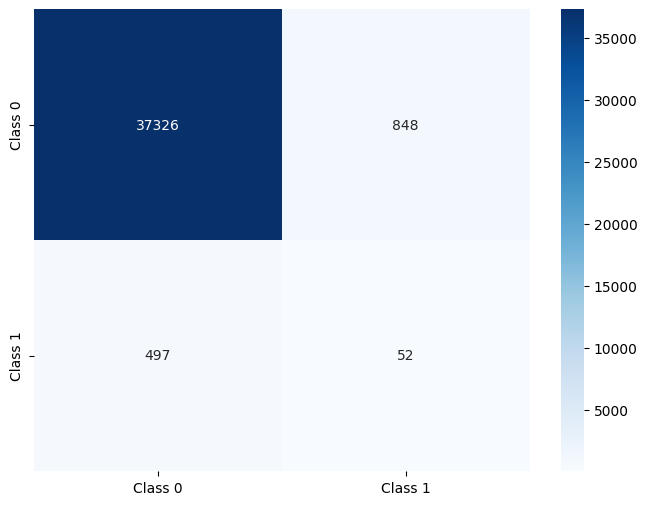

In [ ]:
#plot confusion matrix
cm = confusion_matrix(y_test1, y_pred_vc_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

In [ ]:
#print classification report
print(classification_report(y_test1, y_pred_vc_2))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     38174
         1.0       0.06      0.09      0.07       549

    accuracy                           0.97     38723
   macro avg       0.52      0.54      0.53     38723
weighted avg       0.97      0.97      0.97     38723



###**XGBoost**

In [ ]:
!pip install xgboost

In [ ]:
!pip install --upgrade scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
from xgboost import XGBClassifier

In [ ]:
#xgb1 = XGBClassifier(random_state = 42)
#xgb1.fit(X_train_adasyn1, y_train_adasyn1)

###**MLPClassifier**

In [ ]:
#MLPClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(random_state = 42)
mlp.fit(X_train_adasyn1, y_train_adasyn1)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [ ]:
y_pred_mlp = mlp.predict(X_test1)
print(accuracy_score(y_test1, y_pred_mlp))
y_pred_proba_mlp = mlp.predict_proba(X_test1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba_mlp)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

0.9411719133331612
AUC: 0.5364702284606138


###**Stacking Classifier**

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
base_learners = [('rfc',RandomForestClassifier(random_state = 42, class_weight = 'balanced')),
                 ('gbc',GradientBoostingClassifier(random_state = 42))]

In [ ]:
meta_learner = LogisticRegression(random_state = 42, class_weight = 'balanced')

In [ ]:
start_pred = time.time()
stack_clf = StackingClassifier(estimators = base_learners, final_estimator = meta_learner)
stack_clf.fit(X_train_adasyn1, y_train_adasyn1)
end_pred = time.time()
print(f"Model building Time: {end_pred - start_pred:.2f} seconds")

Model building Time: 599.61 seconds


In [ ]:
(end_pred - start_pred)/60

9.993524702390035

In [ ]:
y_pred_stc = stack_clf.predict(X_test1)
print(accuracy_score(y_test1, y_pred_stc))
y_pred_proba_stc = stack_clf.predict_proba(X_test1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba_stc)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

0.9707925522299409
AUC: 0.7359227542617777


In [ ]:
#print classification report
print(classification_report(y_test1, y_pred_stc))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     38172
         1.0       0.06      0.07      0.06       551

    accuracy                           0.97     38723
   macro avg       0.52      0.53      0.52     38723
weighted avg       0.97      0.97      0.97     38723



###**SVC**

In [ ]:
svc = SVC(random_state = 42, class_weight = 'balanced')
svc.fit(X_train_adasyn1, y_train_adasyn1)

SVC(class_weight='balanced', random_state=42)

###**RandomOverSampler**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state = 42, sampling_strategy = 'minority')
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [ ]:
# Check the new class distribution
print("Before ROS:", y_train.value_counts())
print("")
print("After ROS:", y_train_ros.value_counts())
print("")
print("X_train original shape:", X_train.shape)
print("")
print("X_train_ros shape:", X_train_ros.shape)

Before ROS: bad_flag
0.0    57260
1.0      823
Name: count, dtype: int64

After ROS: bad_flag
0.0    57260
1.0    57260
Name: count, dtype: int64

X_train original shape: (58083, 50)

X_train_ros shape: (114520, 50)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

lr2 = LogisticRegression(random_state = 42, class_weight = 'balanced')
dtc2 = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')
rfc2 = RandomForestClassifier(random_state = 42, class_weight = 'balanced')
gbc2 = GradientBoostingClassifier(random_state = 42)

vc2 = VotingClassifier(estimators = [('lr2', lr2), ('dtc2', dtc2), ('rfc2', rfc2),('gbc2',gbc2)], voting = 'soft')
vc2.fit(X_train_ros, y_train_ros)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr2',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=42)),
                             ('dtc2',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('rfc2',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('gbc2',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [ ]:
y_pred_vc_2 = vc2.predict(X_test1)
print(accuracy_score(y_test1, y_pred_vc_2))
y_pred_proba_vc2 = vc2.predict_proba(X_test1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba_vc2)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

0.9856674327918808
AUC: 0.7515760925216077


In [ ]:
print(classification_report(y_test1, y_pred_vc_2))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     38174
         1.0       0.00      0.00      0.00       549

    accuracy                           0.99     38723
   macro avg       0.49      0.50      0.50     38723
weighted avg       0.97      0.99      0.98     38723

